In [651]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.func import jacrev, jacfwd

In [1178]:
NODE_NUM = 50
TIME_STEPS = 100
torch.set_default_dtype(torch.float64)

In [1157]:
# Define the system
class FSystem:
    def __init__(self):
        self.f = lambda x: x + torch.sin(x)
        
    def func(self, x):
        x = torch.tensor(x)
        return self.f(x).numpy()
    
    def jacobian(self, x):
        x = torch.tensor(x)
        f_jac = torch.vmap(jacfwd(self.f))
        return f_jac(x).numpy()

In [1158]:
class HSystem:
    def __init__(self, node_num=NODE_NUM):
        self.h1 = lambda x: torch.tensor([0., 1.]) @ (x * torch.sin(x))
        self.h2 = lambda x: torch.tensor([1., 0.]) @ (x - torch.cos(x))
        self.node_classification = torch.tensor(np.random.binomial(1, 0.5, (node_num,1)))
        
    def func(self, x, n_expansions=0):
        x = torch.Tensor(x)
        node_classification = self.node_classification
        for i in range(n_expansions):
            node_classification = node_classification[:, None]
        result = node_classification * self.h1(x) + (1 - node_classification) * self.h2(x)
        return result.numpy()
    
    def jacobian(self, x, n_expansions=0):
        x = torch.Tensor(x)
        h1_jac = torch.vmap(jacfwd(self.h1))
        # print(h1_jac(x).shape)
        h2_jac = torch.vmap(jacfwd(self.h2))
        node_classification = self.node_classification
        for i in range(n_expansions):
            node_classification = node_classification[:, None]
        result = node_classification * h1_jac(x) + (1 -node_classification) * h2_jac(x)
        return result.numpy()

In [1159]:
def generate_data_points(f, q, x0, n_point):
    noise_shape = x0.shape + (n_point,)
    w = q * np.random.randn(*noise_shape)
    data_points = np.zeros(shape=noise_shape)
    x = x0
    for i in range(n_point):
        x = f(x) + w[..., i]
        data_points[..., i] = x
    return data_points

def generate_measurements(h, data_points, r_array):
    z = h(data_points, n_expansions=1)
    noise_shape = z.shape
    # print(z)
    v = r_array[:, None,None] * np.random.randn(*noise_shape)
    measurements = z + v
    return  measurements

In [1160]:
def centralized_extended_kalman_fiter(measurements, f_system, h_system, r_array, q, P0, x0):
    x_hat = np.zeros((TIME_STEPS, 2, 1))
    measurements = measurements.transpose(2, 0, 1)
    R_inv = 1 / (r_array**2)
    P = NODE_NUM * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        H_T = h_system.jacobian(x_pred[None,...], 1)[0, ...]
        H = H_T.transpose((0, 2, 1))
        y_hat = measurements[i, ...,None] - h_system.func(x_pred[None,...], 1) + H @ x_pred
        node_s = H_T @ R_inv[:, None, None] @ H
        y_node = H_T @ R_inv[:, None, None] @ measurements[i, ...,None]
        s_all = np.sum(node_s, axis=0) / NODE_NUM
        y_all = np.sum(y_node, axis=0) / NODE_NUM
        M = np.linalg.inv(np.linalg.inv(P) + s_all)
        x_current = x_pred + M @ (y_all - s_all @ x_pred)
        F = f_system.jacobian(x_current[None, ..., 0])[0, ...]
        P = F @ M @ F.T + NODE_NUM * q**2 * np.eye(2)
        x_pred = f_system.func(x_current)
        x_hat[i, ...] = x_current
    return x_hat

In [1161]:
def local_extended_kalman_fiter(measurements, f_system, h_system, r_array, q, P0, x0, j_matrix):
    x_hat = np.zeros((TIME_STEPS, NODE_NUM, 2, 1))
    R_inv = 1 / (r_array**2)
    measurements = measurements.transpose(2, 0, 1)
    P = j_matrix.sum(axis=0)[..., None, None] * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        if i == 0:
            H_T = h_system.jacobian(x_pred[None,...], 1)[0, ...]
        else:
            H_T = h_system.jacobian(x_pred, 1)[0, ...]
        H = H_T.transpose((0, 2, 1))
        node_s = H_T @ R_inv[:, None, None] @ H
        y_node = H_T @ R_inv[:, None, None] @ measurements[i, ...,None]
        s_local = np.einsum('ij, jmk -> imk', j_matrix, node_s) / j_matrix.sum(axis=0)[..., None, None]
        y_local = np.einsum('ij, jmk -> imk', j_matrix, y_node) / j_matrix.sum(axis=0)[..., None, None]
        M = np.linalg.inv(np.linalg.inv(P) + s_local)
        x_current = x_pred + M @ (y_local - s_local @ x_pred)
        F = f_system.jacobian(x_current[..., 0])[0, ...]
        P = F @ M @ F.T + j_matrix.sum(axis=0)[..., None, None] * q**2 * np.eye(2)
        x_pred = f_system.func(x_current)
        x_hat[i, ...] = x_current
    return x_hat

In [1162]:
def alg_3_extended_kalman_filter(measurements, f_system, h_system, r_array, q, P0, x0, j_matrix, eps=0.001):
    x_hat = np.zeros((TIME_STEPS, NODE_NUM, 2, 1))
    R_inv = 1 / (r_array**2)
    measurements = measurements.transpose(2, 0, 1)
    P = j_matrix.sum(axis=0)[..., None, None] * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        if i == 0:
            H_T = h_system.jacobian(x_pred[None,...], 1)[0, ...]
        else:
            H_T = h_system.jacobian(x_pred, 1)[0, ...]
        H = H_T.transpose((0, 2, 1))
        node_s = H_T @ R_inv[:, None, None] @ H
        y_node = H_T @ R_inv[:, None, None] @ measurements[i, ...,None]
        s_local = np.einsum('ij, jmk -> imk', j_matrix, node_s) / j_matrix.sum(axis=0)[..., None, None]
        y_local = np.einsum('ij, jmk -> imk', j_matrix, y_node) / j_matrix.sum(axis=0)[..., None, None]
        M = np.linalg.inv(np.linalg.inv(P) + s_local)
        if i == 0:
            x_current = x_pred + M @ (y_local - s_local @ x_pred)
        else:
            x_diff_pred_neighborhood = (np.einsum('ij, jmk -> imk', j_matrix, x_pred) - j_matrix.sum(axis=0)[..., None, None] * x_pred)
            x_diff_pred_neighborhood = x_diff_pred_neighborhood / (j_matrix.shape[0] * 5)
            x_diff_pred_neighborhood[x_diff_pred_neighborhood > 10] = 10
            # print(x_diff_pred_neighborhood)
            x_current = x_pred + M @ (y_local - s_local @ x_pred) + (eps * M) @ x_diff_pred_neighborhood
        F = f_system.jacobian(x_current[..., 0])[0, ...]
        P = F @ M @ F.T + j_matrix.sum(axis=0)[..., None, None] * q**2 * np.eye(2)
        x_pred = f_system.func(x_current)
        x_hat[i, ...] = x_current
    return x_hat

In [1179]:
f_sys = FSystem()
x_points = generate_data_points(f_sys.func, 1, np.array([1, -1]).T, TIME_STEPS)

In [1180]:
r_array = np.linspace(1, NODE_NUM+1)**0.125
meas = generate_measurements(HSystem().func, x_points, r_array)

In [1181]:
meas.shape

(50, 1, 100)

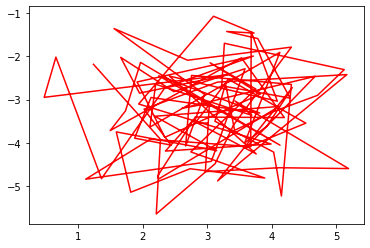

In [1182]:
# Plot the data 
node_idx = 3
plt.plot(x_points[0, :], x_points[1, :], 'r')
# plt.plot(meas[node_idx, 0, :], meas[node_idx, 1, :], 'b')
plt.show()

In [1188]:
q = 1
P0 = np.cov(x_points)
x0 = np.array([[100, -100],]).T
g = nx.connected_watts_strogatz_graph(NODE_NUM, 5, 0.4, seed=42)
adj_matrix = nx.adjacency_matrix(g)
j_matrix = adj_matrix + np.eye(NODE_NUM)
x_hat_kalman = centralized_extended_kalman_fiter(meas, FSystem(), HSystem(), r_array, q, P0, x0)
x_hat_local_kalman = local_extended_kalman_fiter(meas, FSystem(), HSystem(), r_array, q, P0, x0, j_matrix)
x_hat_alg_3 = alg_3_extended_kalman_filter(meas, FSystem(), HSystem(), r_array, q, P0, x0, j_matrix)

In [1189]:
err_kalman = np.linalg.norm(x_hat_kalman - x_points.T[..., None], axis=(1,2))
err_local_kalman = np.linalg.norm(x_hat_local_kalman - x_points.T[:, None,..., None].repeat(NODE_NUM, axis=1), axis=(-1,-2)).mean(axis=1)
err_alg_3 = np.linalg.norm(x_hat_alg_3 - x_points.T[:, None,..., None].repeat(NODE_NUM, axis=1), axis=(-1,-2)).mean(axis=1)

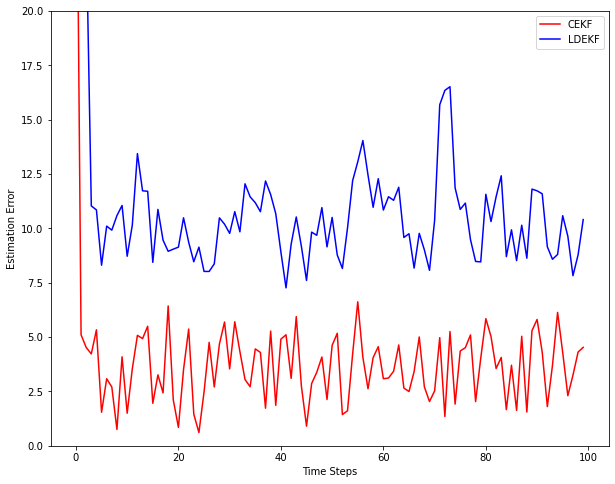

In [1191]:
plt.figure(figsize=(10, 8))
plt.plot(err_kalman, 'r', label='CEKF')
plt.plot(err_local_kalman, 'b', label='LDEKF')
# plt.plot(err_alg_3, 'g', label='Alg-3')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Estimation Error')
plt.ylim([0, 20])
plt.show()

# x_hat_kalman.shape

In [1079]:
np.cov(x_points)

array([[8.6337127 , 1.94855449],
       [1.94855449, 2.22878202]])